In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gurobipy import *

sns.set(style ="whitegrid", font_scale=1.5)
from matplotlib.ticker import MultipleLocator
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
custom_colors = ["#c45161", "#e094a0", "#f2b6c0", "#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)
color_palette = np.array(["#c45161", "#e094a0", "#f2b6c0", "#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"])
matplotlib.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

In [2]:
demand = pd.read_csv('../input/schedule_5min_0612.csv')
demand = demand.sample(n=50).sort_values(by='schedule').reset_index(drop=True)
demand['schedule'] = demand['schedule'] // 5 + 1
demand['origin'] = demand['od'].apply(lambda x: x.split('_')[0])
demand['destination'] = demand['od'].apply(lambda x: x.split('_')[1])

In [3]:
cs = np.array([0, 0.0129,0.0133,0.0137,0.0142,0.0147,
                                0.0153,0.0158,0.0166,0.0172,0.018,
                                0.0188,0.0197,0.0207,0.0219,0.0231,
                                0.0245,0.026,0.0278,0.03,0.0323,
                                0.0351,0.0384,0.0423,0.0472,0.0536,
                                0.0617,0.0726,0.0887,0.1136,0.1582,
                                0.2622,0.9278,])*60
cs = np.cumsum(cs)

In [4]:
K = 2
N = demand.shape[0]+2
S = np.arange(33)
alpha_s = np.arange(0.2, 1.025, 0.025)
M = 1e3


d = demand['schedule'].values * 5
d = np.insert(d, 0, 0)
d = np.append(d, 291*5)


t = np.array([10 for i in range(N)])
t[0] = 0
t[-1] = 0


tilt = np.zeros(shape=(N, N))
gamma = np.array([0.1 for i in range(N)])
gamma[0] = 0
gamma[-1] = 0

tilgamma = np.zeros(shape=(N, N))

for idx, row in demand.iterrows():
    for idx2, row2 in demand.iterrows():
        if idx < idx2:
            if row['destination'] == row2['origin']:
                tilt[idx+1, idx2+1] = 0
                tilgamma[idx+1, idx2+1] = 0
            else:
                tilt[idx+1, idx2+1] = 10
                tilgamma[idx+1, idx2+1] = 0.1

            

In [5]:
m = Model("eVRP")

x_ijk = [(i, j, k) for i in range(N) for j in range(N) for k in range(K) if i < j]
x_ijk = m.addVars(x_ijk, vtype=GRB.BINARY, name='x')

alpha_isk = [(i, s, k) for i in range(N) for s in S for k in range(K)]
alpha_isk = m.addVars(alpha_isk, vtype=GRB.BINARY, name='alpha')

beta_isk = [(i, s, k) for i in range(N) for s in S for k in range(K)]
beta_isk = m.addVars(beta_isk, vtype=GRB.BINARY, name='beta')

p_ik = [(i, k) for i in range(N) for k in range(K)]
p_ik = m.addVars(p_ik, vtype=GRB.CONTINUOUS, name='p')

q_ik = [(i, k) for i in range(N) for k in range(K)]
q_ik = m.addVars(q_ik, vtype=GRB.CONTINUOUS, name='q')

w_ik = [(i, k) for i in range(N) for k in range(K)]
w_ik = m.addVars(w_ik, vtype=GRB.CONTINUOUS, name='w')

v_ik = [(i, k) for i in range(N) for k in range(K)]
v_ik = m.addVars(v_ik, vtype=GRB.CONTINUOUS, name='v')

m_isk = [(i, s, k) for i in range(N) for s in S for k in range(K)]
m_isk = m.addVars(m_isk, vtype=GRB.BINARY, name='m')

n_isk = [(i, s, k) for i in range(N) for s in S for k in range(K)]
n_isk = m.addVars(n_isk, vtype=GRB.BINARY, name='n')

s_ik = [(i, k) for i in range(N) for k in range(K)]
s_ik = m.addVars(s_ik, vtype=GRB.CONTINUOUS, name='s')

Delta_ik = [(i, k) for i in range(N) for k in range(K)]
Delta_ik = m.addVars(Delta_ik, vtype=GRB.CONTINUOUS, name='Delta')

delta_ik = [(i, k) for i in range(N) for k in range(K)]
delta_ik = m.addVars(delta_ik, vtype=GRB.CONTINUOUS, name='delta')

g_ik = [(i, k) for i in range(N) for k in range(K)]
g_ik = m.addVars(g_ik, vtype=GRB.CONTINUOUS, name='g')

m.setObjective(sum(x_ijk[i, j, k] for i in range(1, N-1) for j in range(N) for k in range(K) if i < j), GRB.MAXIMIZE)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-07


In [6]:
for i in range(1, N-1):
    m.addConstr(x_ijk.sum(i, '*', '*') <= 1) # CONSTRAINT (1)

for k in range(K):
    m.addConstr(x_ijk.sum(0, '*', k) == 1) # CONSTRAINT (2)
    m.addConstr(x_ijk.sum('*', N-1, k) == 1) # CONSTRAINT (2)


for i in range(1, N-1):
    for k in range(K):
        m.addConstr(sum(x_ijk[j, i, k] for j in range(N-1) if j < i) - sum(x_ijk[i, j, k] for j in range(1, N) if i < j) == 0) # CONSTRAINT (4)


for k in range(K):
    for i in range(N):
        # Before charging
        m.addConstr(p_ik[i, k] == sum(alpha_isk[i, s, k]*alpha_s[s] for s in S)) # CONSTRAINT (5)
        m.addConstr(w_ik[i, k] == sum(alpha_isk[i, s, k]*cs[s] for s in S)) # CONSTRAINT (6)
        m.addConstr(alpha_isk.sum(i, '*', k) == sum(m_isk[i, s, k] for s in S if s != 0)) # CONSTRAINT (7)
        m.addConstr(sum(m_isk[i, s, k] for s in S if s != 0) == sum(x_ijk[i, j, k] for j in range(N) if i < j)) # CONSTRAINT (8)
        m.addConstr(alpha_isk[i, 0, k] <= m_isk[i, 1, k]) # CONSTRAINT (9)
        m.addConstr(alpha_isk[i, max(S), k] <= m_isk[i, max(S), k]) # CONSTRAINT (11)

        # After charging
        m.addConstr(q_ik[i, k] == sum(beta_isk[i, s, k]*alpha_s[s] for s in S)) # CONSTRAINT (12)
        m.addConstr(v_ik[i, k] == sum(beta_isk[i, s, k]*cs[s] for s in S)) # CONSTRAINT (13)
        m.addConstr(beta_isk.sum(i, '*', k) == sum(n_isk[i, s, k] for s in S if s != 0)) # CONSTRAINT (14)
        m.addConstr(sum(n_isk[i, s, k] for s in S if s != 0) == sum(x_ijk[i, j, k] for j in range(N) if i < j)) # CONSTRAINT (15)
        m.addConstr(beta_isk[i, 0, k] <= n_isk[i, 1, k]) # CONSTRAINT (16)
        m.addConstr(beta_isk[i, max(S), k] <= n_isk[i, max(S), k]) # CONSTRAINT (18)


        m.addConstr(Delta_ik[i, k] == v_ik[i, k] - w_ik[i, k]) # CONSTRAINT (19)
    
        for s in range(1, len(S)-1):
            m.addConstr(alpha_isk[i, s, k] <= m_isk[i, s, k] + m_isk[i, s+1, k]) # CONSTRAINT (10)
            m.addConstr(beta_isk[i, s, k] <= n_isk[i, s, k] + n_isk[i, s+1, k]) # CONSTRAINT (17)


for k in range(K):
    for i in range(N):
        m.addConstr(g_ik[i, k] == d[i] + t[i]) # CONSTRAINT (20)
        for j in range(N):
            if i < j:
                m.addConstr(g_ik[i, k] + Delta_ik[i, k] + t[j] + tilt[i, j] - g_ik[j, k] <= M * (1 - x_ijk[i, j, k])) # CONSTRAINT (21)

for k in range(K):
    m.addConstr(p_ik[0, k] == 1) # CONSTRAINT (22)
    m.addConstr(q_ik[0, k] == 1) # CONSTRAINT (23)


for k in range(K):
    for i in range(N):
        for j in range(N-1):
            if i < j:
                m.addConstr(q_ik[i, k] - gamma[j] - tilgamma[i, j] - p_ik[j, k] <= M * (1 - x_ijk[i, j, k])) # CONSTRAINT (24)
                m.addConstr(q_ik[i, k] - gamma[j] - tilgamma[i, j] - p_ik[j, k] >= -M * (1 - x_ijk[i, j, k])) # CONSTRAINT (25)


for k in range(K):
    for i in range(N):
        # Define domain
        m.addConstr(w_ik[i, k] >= 0) 
        m.addConstr(v_ik[i, k] >= 0)
        m.addConstr(Delta_ik[i, k] >= 0)
        m.addConstr(p_ik[i, k] >= 0)
        m.addConstr(q_ik[i, k] >= 0)

In [7]:
m.update()
m.Params.MIPGap = 0.001
m.Params.FeasibilityTol = 1e-4
m.Params.threads = 8
m.optimize()

Set parameter MIPGap to value 0.001
Set parameter FeasibilityTol to value 0.0001
Set parameter Threads to value 8
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 8 threads

Optimize a model with 16334 rows, 17212 columns and 94294 nonzeros
Model fingerprint: 0xabb71f44
Variable types: 832 continuous, 16380 integer (16380 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 3766 rows and 1346 columns
Presolve time: 0.17s
Presolved: 12568 rows, 15866 columns, 80266 nonzeros
Variable types: 0 continuous, 15866 integer (15472 binary)
Found heuristic solution: objective -0.0000000

Root relaxation: objective 4.700000e+01, 3141 iterations, 0.14 seconds (0.29 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |

In [49]:

x_vars = []
Delta_vars = []

# for var in m.getVars():
#     if var.x > 1e-3:
#         print('%s %g' % (var.varName, var.x))

for var in m.getVars():
    if var.VarName.startswith('x'):
        x_vars.append([var.VarName, var.x])

    if var.VarName.startswith('Delta'):
        Delta_vars.append([var.VarName, var.x])


In [53]:
Delta_df = pd.DataFrame(Delta_vars, columns=['var', 'value'])
Delta_df[['i', 'k']] = Delta_df['var'].str.extract(r'Delta\[(\d+),(\d+)\]').astype(int)
Delta_df = Delta_df.drop(columns=['var'])
Delta_df

,value,i,k
0,0.00,0,0
1,0.00,0,1
2,0.00,1,0
3,32.04,1,1
4,0.00,2,0
...,...,...,...
99,0.00,49,1
100,0.00,50,0
101,0.00,50,1
102,0.00,51,0


In [62]:
x_df = pd.DataFrame(x_vars, columns=['var', 'val'])
x_df[['i', 'j', 'k']] = x_df['var'].str.extract(r'\[(\d+),(\d+),(\d+)\]').astype(int)
x_df = x_df.drop(columns=['var'])
x_df['arrival_time'] = x_df['j'].apply(lambda x: d[x] + t[x])

In [74]:
x_df_filtered = x_df[(x_df['val'] > 1e-3) & (x_df['j'].isin(range(1, N-1)))]
x_df_filtered = x_df_filtered[['j','k','arrival_time']].merge(Delta_df, left_on=['j', 'k'], right_on=['i', 'k'], how='inner')

x_df_filtered['departure_time'] = x_df_filtered['arrival_time'] + x_df_filtered['value']

In [76]:
x_df_filtered['location'] = x_df_filtered['j'].apply(lambda x: demand.loc[x-1, 'destination'])

In [126]:
v0 = x_df_filtered[x_df_filtered['k'] == 0][['arrival_time', 'departure_time', 'location']].reset_index(drop=True)
v1 = x_df_filtered[x_df_filtered['k'] == 1][['arrival_time', 'departure_time', 'location']].reset_index(drop=True)

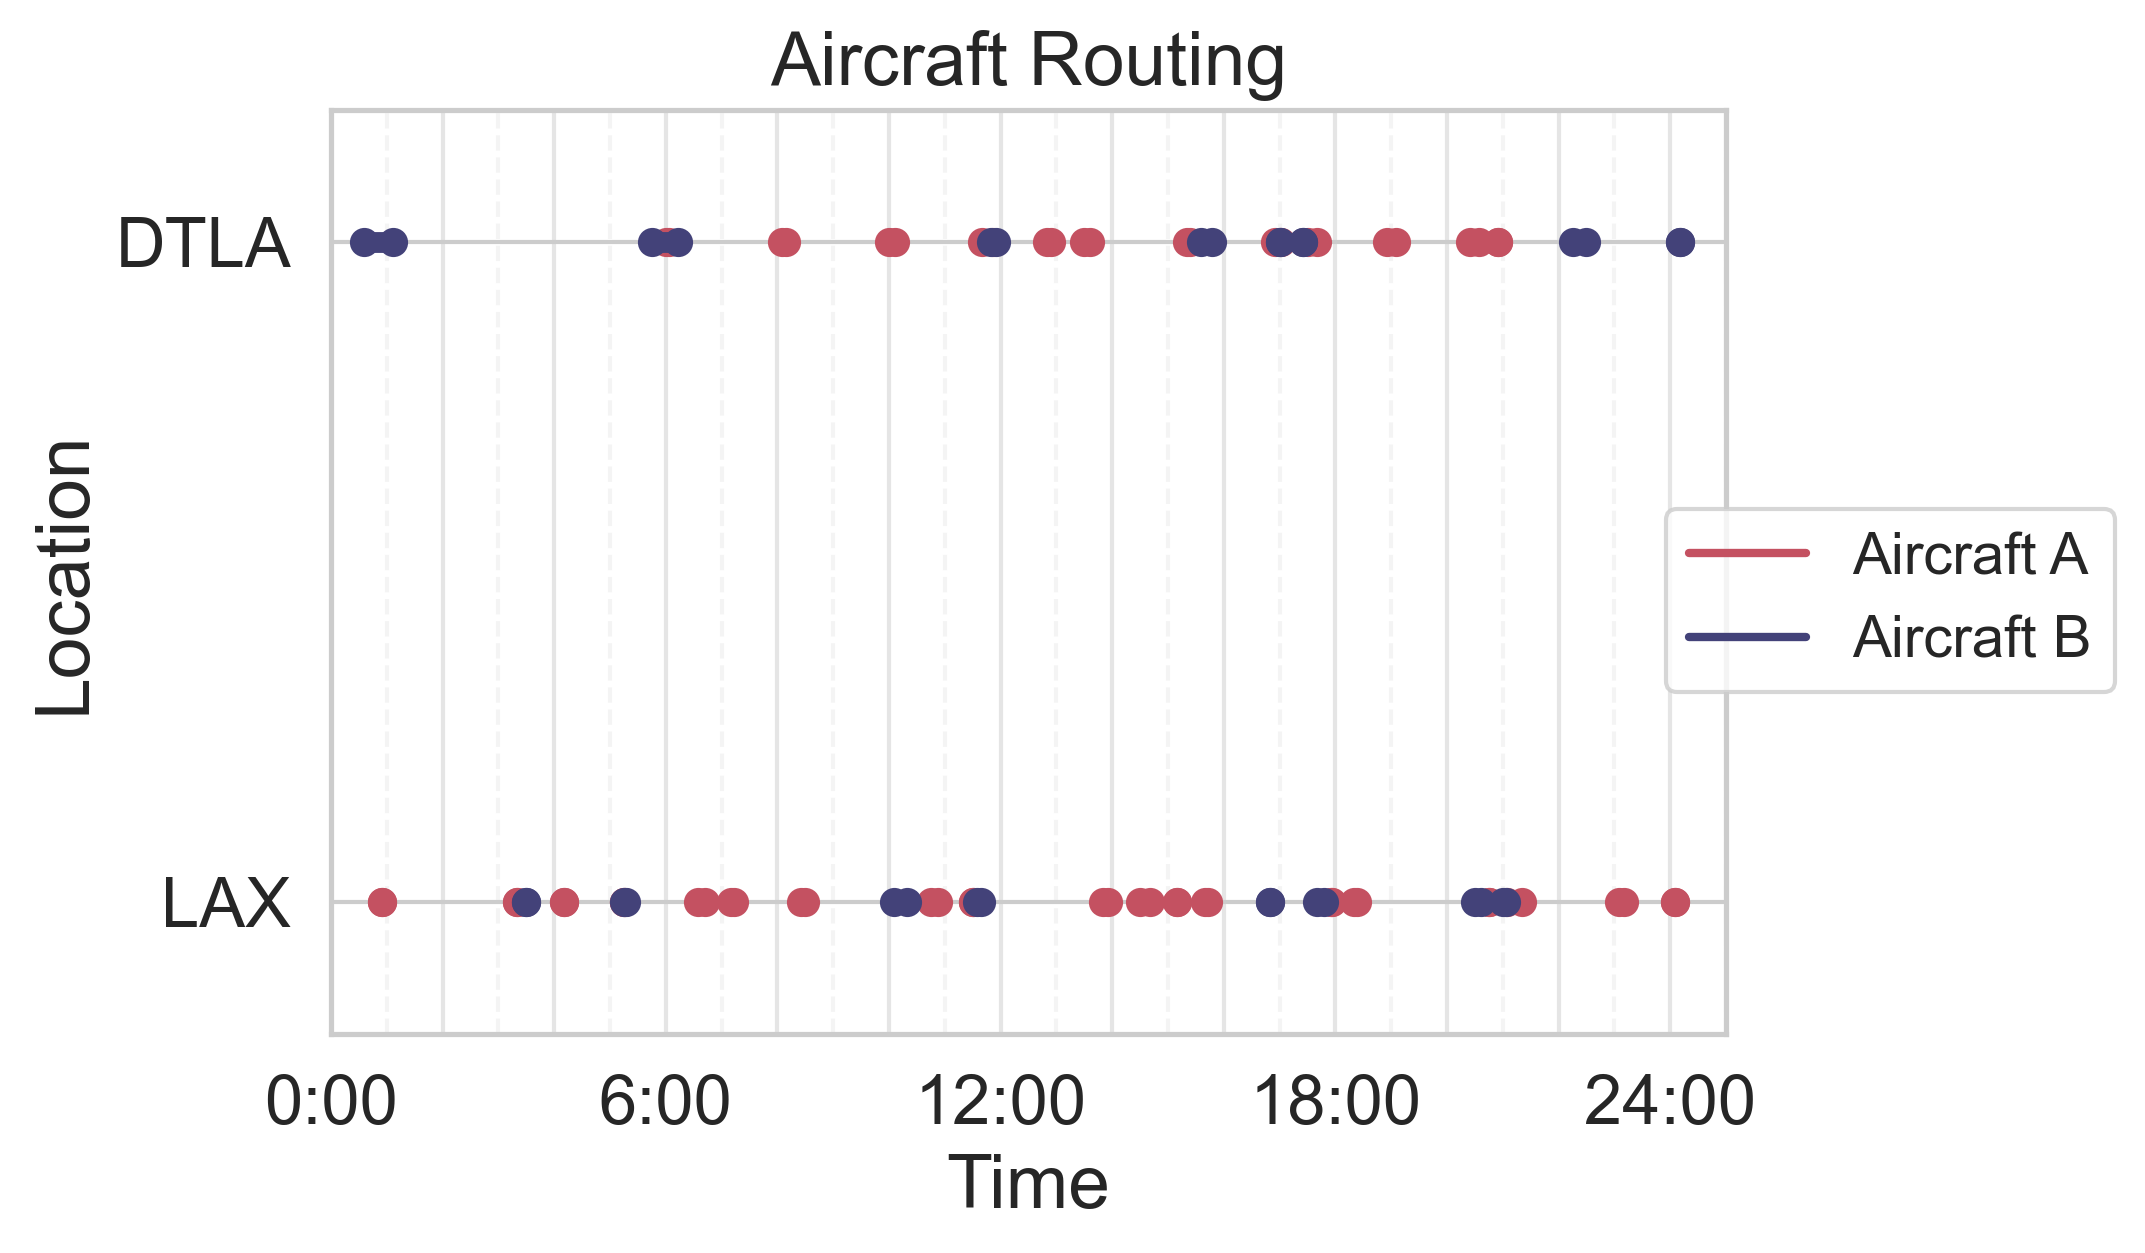

In [136]:
# Create the plot

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)


# Loop through each row and plot the segment for each location between arrival and departure time
for i in range(len(v0)):
    ax.plot([v0['arrival_time'][i], v0['departure_time'][i]], [v0['location'][i], v0['location'][i]], 
              marker='o', color=color_palette[0], markersize=6, linewidth=5, label='Vehicle 0')

for i in range(len(v1)):    
    ax.plot([v1['arrival_time'][i], v1['departure_time'][i]], [v1['location'][i], v1['location'][i]],
              marker='o', color=color_palette[-1], markersize=6, linewidth=5, label='Vehicle 1')

ax.set(xlim=(0, 1440+60), ylim=(-0.2, 1.2), xlabel='Time', ylabel='Location',
             xticks=np.arange(0, 1440+60, 60*6),  xticklabels=['0:00', '6:00', '12:00', '18:00', '24:00'],
             title='Aircraft Routing')



minorLocator = MultipleLocator(60)
majorLocator = MultipleLocator(120)
ax.xaxis.set_minor_locator(minorLocator)
ax.xaxis.set_major_locator(majorLocator)
ax.grid(which='minor', axis='x', linestyle='--', alpha=0.2)
ax.grid(which='major', axis='x', linestyle='-', alpha=0.5)
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color=color_palette[0], lw=2, label='Aircraft A'),
                   Line2D([0], [0], color=color_palette[-1], lw=2, label='Aircraft B')]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 0.6))

In [137]:
v1

,arrival_time,departure_time,location
0,35.0,67.040,DTLA
1,210.0,210.000,LAX
2,315.0,316.938,LAX
3,345.0,373.020,DTLA
4,605.0,619.106,LAX
5,695.0,699.044,LAX
6,710.0,715.406,DTLA
7,935.0,947.378,DTLA
8,1010.0,1010.000,LAX
9,1020.0,1020.000,DTLA
